In [1]:
from geopy.geocoders import Nominatim
import h3
from geographiclib.geodesic import Geodesic
import numpy as np
import matplotlib.pyplot as plt
h3.__version__

'3.7.4'

In [2]:
geolocator = Nominatim(user_agent="h3_vs_ellipsoidal_distances")

In [3]:
# Geocodificar (lat, long) una direccion (string)
def geocodificar(direccion):
    location = geolocator.geocode(direccion)
    return (location.latitude, location.longitude)

In [4]:
# Calcular la distancia haversine (radio autalico wgs84), en metros, desde src a dst
def h3_distance(src, dst):
    return h3.point_dist(src, dst, unit='m')

In [5]:
# Define el elipsoide WGS84
geod = Geodesic.WGS84

In [6]:
# Calcular la distancia elipsoidal wgs84, en metros, de src a dst
def ellps_distance(src, dst):
    return geod.Inverse(src[0], src[1], dst[0], dst[1])['s12']

In [7]:
# Imprimir distancias haversine y elipsoidal, en metros
# y diferencias, en metros y porcentual (respecto de elipsoidal)
def imprimir_dist(src, dst):
    h3_dist = h3_distance(src, dst)
    ellps_dist = ellps_distance(src, dst)
    diff_mts = h3_dist - ellps_dist
    diff_perc = diff_mts * 100 / ellps_dist
    print(f'Distancia H3 = {h3_dist} m\n'+
          f'Distancia elipsoidal = {ellps_dist} m\n'+
          f'Diferencia en metros = {diff_mts} m\n'+
          f'Diferencia porcentual = {diff_perc} %')

In [8]:
imprimir_dist(geocodificar('South Africa'), geocodificar('Netherlands'))

Distancia H3 = 9208637.410339316 m
Distancia elipsoidal = 9175894.689689312 m
Diferencia en metros = 32742.720650004223 m
Diferencia porcentual = 0.3568340936475249 %


In [9]:
imprimir_dist(geocodificar('California'), geocodificar('Taiwan'))

Distancia H3 = 10814737.412639704 m
Distancia elipsoidal = 10833905.73274799 m
Diferencia en metros = -19168.320108287036 m
Diferencia porcentual = -0.17692899108717872 %


In [10]:
imprimir_dist(geocodificar('Australia'), geocodificar('Malasya'))

Distancia H3 = 4793739.955957866 m
Distancia elipsoidal = 4785801.500724654 m
Diferencia en metros = 7938.45523321256 m
Diferencia porcentual = 0.16587514613822868 %


In [11]:
# Crea un punto de origen para calcular las distancias (lat, lon)
src = (0, 0)

In [12]:
# Crea una matriz de base (rows, cols, bands) y su bounding box (ullr)
base = np.zeros((181, 361, 2), dtype=np.float32)
base_ullr = (90, -180, -90, 180)

In [13]:
# Obtener el pixel size (height, width)
def get_ps(ullr, shape):
    ps_height = -(ullr[2]-ullr[0])/shape[0]
    ps_width = (ullr[3]-ullr[1])/shape[1]
    return (ps_height, ps_width)
base_ps = get_ps(base_ullr, base.shape)
base_ps

(0.994475138121547, 0.997229916897507)

In [14]:
# Obtener las coordenadas en grados, dadas las coordenadas del pixel (rowcol)
def rowcol2degs(rowcol, ullr, ps):
    y = ullr[0] - (ps[0] * (rowcol[0] + 0.5))
    x = ullr[1] + (ps[1] * (rowcol[1] + 0.5))
    return (y, x)

In [15]:
rowcol2degs((90, 180), base_ullr, base_ps)

(0.0, 0.0)

In [16]:
# Llenar un array con las diferencias en metros y porcentual (respecto de elipsoidal)
# entre distancias desde un punto src (lat, lon)
def diferencias(array, array_ullr, array_ps, src):
    for row in range(array.shape[0]):
        for col in range (array.shape[1]):
            dst = rowcol2degs((row, col), array_ullr, array_ps)
            h3_dist = h3_distance(src, dst)
            ellps_dist = ellps_distance(src, dst)
            diff_mts = h3_dist - ellps_dist
            if ellps_dist == 0:
                diff_perc = 0
            else:
                diff_perc = diff_mts * 100 / ellps_dist
            base[row, col, :] = [diff_mts, diff_perc]
    return base

In [17]:
diffs = diferencias(base, base_ullr, base_ps, src)

In [18]:
# Plotear un array en coordenadas del mapa (yx)
def plotear(array, ullr, title):
    array_extent = (ullr[1], ullr[3], ullr[2], ullr[0]) #(left, right, bottom, top)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(title)
    array_plt = plt.imshow(array, cmap='Spectral', extent=array_extent)
    plt.colorbar()
    return array_plt

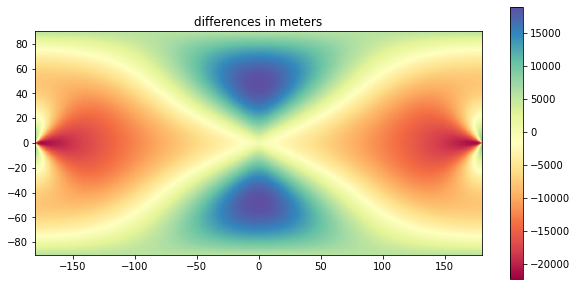

In [19]:
plot_mts = plotear(diffs[:,:,0], base_ullr, 'differences in meters')

In [20]:
# Imprimir estadisticas basicas del array
def imprimir_estadisticas(array):
    print(f'Min = {np.min(array)}\nMax = {np.max(array)}\nMean = {np.mean(array)}')

In [21]:
imprimir_estadisticas(diffs[:,:,0])

Min = -22212.845703125
Max = 18933.1796875
Mean = -513.6322021484375


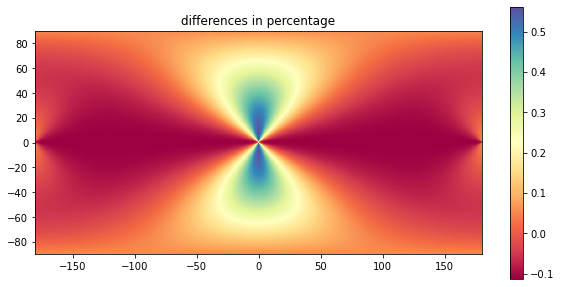

In [22]:
plot_perc = plotear(diffs[:,:,1], base_ullr, 'differences in percentage')

In [23]:
imprimir_estadisticas(diffs[:,:,1])

Min = -0.11178529262542725
Max = 0.5613096356391907
Mean = 0.024669304490089417


In [24]:
#Calcula las diferencias desde otro punto de origen
src = geocodificar('California')
diffs = diferencias(base, base_ullr, base_ps, src)

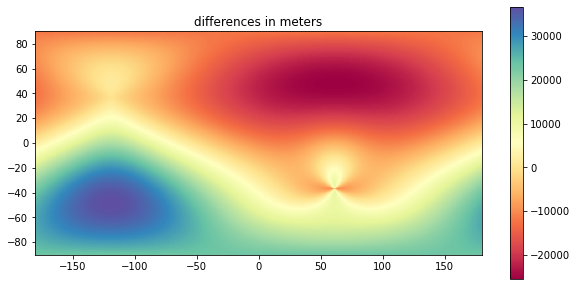

In [25]:
plot_mts = plotear(diffs[:,:,0], base_ullr, 'differences in meters')

In [26]:
imprimir_estadisticas(diffs[:,:,0])

Min = -25395.357421875
Max = 36573.36328125
Mean = 1451.2191162109375


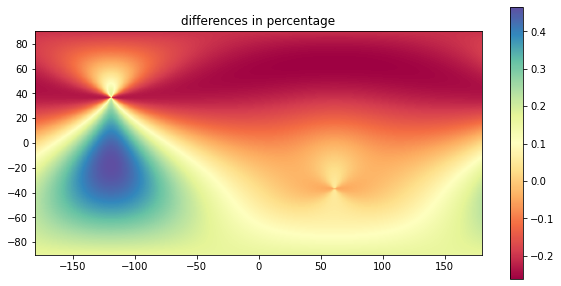

In [27]:
plot_perc = plotear(diffs[:,:,1], base_ullr, 'differences in percentage')

In [28]:
imprimir_estadisticas(diffs[:,:,1])

Min = -0.2612246870994568
Max = 0.4652694761753082
Mean = -0.006956412456929684
